In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
from pydataset import data
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import acquire
import prepare
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

## Data Wrangling:
### Data acquisiton

I want to identify variables that may contribute to churn and implement either the decision tree, random forest, or k nearest neighbor machine learning model to help predict which customers will churn.

first I need to acquire the data from the database.

In [2]:
#the following functions are already defined in the acquire.py file

def new_telco_data():
   
    sql_query = """
                select * from customers
                join contract_types using (contract_type_id)
                join internet_service_types using (internet_service_type_id)
                join payment_types using (payment_type_id)
                """
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('telco_churn'))
    
    return df

def get_telco_data():
    
    if os.path.isfile('telco.csv'):
        
        # If csv file exists read in data from csv file.
        df = pd.read_csv('telco.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame
        df = new_telco_data()
        
        # Cache data
        df.to_csv('telco.csv')
        
    return df
df = acquire.get_telco_data()

In [3]:
#chekcing the data information to identify potential problems early
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

### Data Prep
The 'total_charges' column is showing as an object, but it needs to be a numeric value. 

When attempting to convert the value to a float, I discovered that 11 rows had ' ' entered as a value. Since this is a small number compared to the dataset as a whole the cleanest solution is to conver those values to "NaN" and then drop them

In [4]:
#dropping 'blanks' from the total_charges column
df['total_charges'] = df["total_charges"].replace(' ', np.nan).astype(float)
df = df.dropna()


In [5]:
# removing protect class info from dataframe.
df = df.drop(columns=['gender','senior_citizen','partner','dependents'])

In [6]:
# the following function is already defined in the prepare.py file
def prep_telco(df):
    df = df.drop(columns=['payment_type_id','internet_service_type_id','contract_type_id','customer_id'])
    train, test = train_test_split(df, test_size = .2, random_state=123, stratify=df.churn)
    train, validate = train_test_split(train, test_size=.25, random_state=123, stratify=train.churn)
    return(train,validate,test)

#splitting the data to prevent data leakage from currupting any models
train,validate,test,dummy_list = prepare.prep_telco(df)

In [8]:
train.info()
dummy_list

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4218 entries, 3727 to 1002
Data columns (total 39 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 4218 non-null   int64  
 1   phone_service                          4218 non-null   object 
 2   multiple_lines                         4218 non-null   object 
 3   online_security                        4218 non-null   object 
 4   online_backup                          4218 non-null   object 
 5   device_protection                      4218 non-null   object 
 6   tech_support                           4218 non-null   object 
 7   streaming_tv                           4218 non-null   object 
 8   streaming_movies                       4218 non-null   object 
 9   paperless_billing                      4218 non-null   object 
 10  monthly_charges                        4218 non-null   float64
 11  t

['paperless_billing',
 'online_security',
 'online_backup',
 'device_protection',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines',
 'phone_service',
 'tech_support',
 'contract_type',
 'internet_service_type',
 'payment_type']

### Data Exploration
I will be exploring different variables and try to narrow the focus of what my ML algorithm will have to work through.

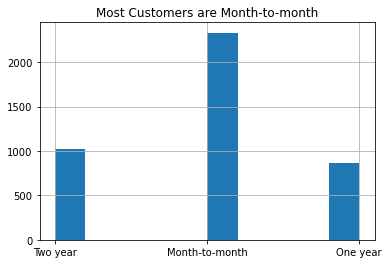

In [9]:
#most customers are getting the opportunity to churn monthly
plt.title('Most Customers are Month-to-month')
train.contract_type.hist()
plt.show()

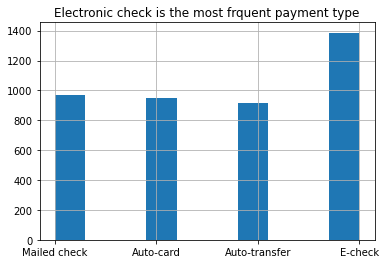

In [13]:
plt.title('Electronic check is the most frquent payment type')
train.payment_type.hist()
plt.xticks([0,1,2,3],['Mailed check','Auto-card','Auto-transfer','E-check'])
plt.show()

In [14]:
# checking to see if streaming services are connected
pd.crosstab(train.streaming_tv,train.streaming_movies)

streaming_movies,No,No internet service,Yes
streaming_tv,,,
No,1196,0,471
No internet service,0,930,0
Yes,445,0,1176


In [15]:
# checking to see if paperless billing correlates with churn
pd.crosstab(train.paperless_billing, train.churn)

churn,No,Yes
paperless_billing,,
No,1445,288
Yes,1652,833


In [16]:
# checking which payment method has the most churn
pd.crosstab(train.churn, train.payment_type)
# E-check has the most churn

payment_type,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
churn,,,,
No,756,797,761,783
Yes,159,154,625,183


In [17]:
# checking which contract type churns most
pd.crosstab(train.churn, train.contract_type)
# month to month has the most churn by far

contract_type,Month-to-month,One year,Two year
churn,,,
No,1339,771,987
Yes,992,98,31


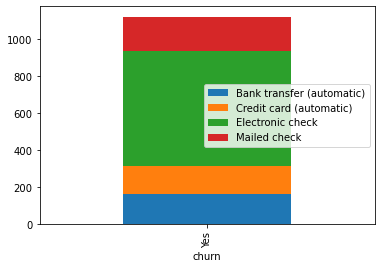

In [18]:
payment_ct = pd.crosstab(train.churn.where(train.churn == 'Yes'), train.payment_type)
payment_ct.plot(kind='bar', stacked = True)
plt.legend()

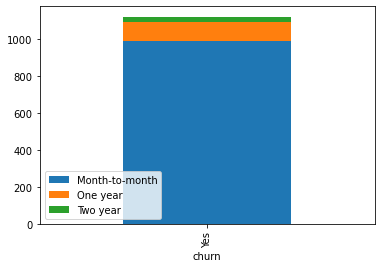

In [19]:
contract_ct = pd.crosstab(train.churn.where(train.churn == 'Yes'), train.contract_type)
contract_ct.plot(kind='bar', stacked = True)
plt.legend()

In [20]:
# the most common payment/contract combo is E-check/month-to-month
pd.crosstab(train.payment_type,train.contract_type)

contract_type,Month-to-month,One year,Two year
payment_type,,,
Bank transfer (automatic),354,240,321
Credit card (automatic),347,240,364
Electronic check,1085,202,99
Mailed check,545,187,234


<AxesSubplot:xlabel='tenure', ylabel='monthly_charges'>

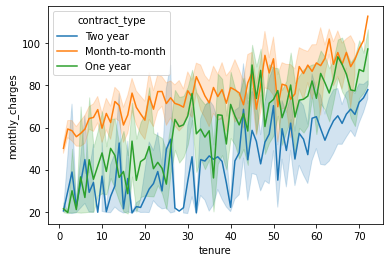

In [21]:
# monthly charges over tenure by payment_types
sns.lineplot(data=train, y='monthly_charges',x='tenure',hue='contract_type')

<AxesSubplot:xlabel='tenure', ylabel='monthly_charges'>

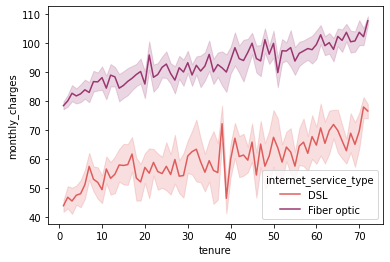

In [22]:
# monthly charges over tenure by internet service types
sns.lineplot(data=train.where(train.internet_service_type!='None'), y='monthly_charges',x='tenure',hue='internet_service_type', palette='flare')


### hypothesis testing

In [23]:
# dependency contract type-churn

contract_churn = pd.crosstab(train.contract_type, train.churn)
chi2, p, degf, expected = stats.chi2_contingency(contract_churn)
chi2, p

(698.1664927314107, 2.4835469729269116e-152)

In [24]:
# dependency payment type-churn

payment_churn = pd.crosstab(train.payment_type, train.churn)
chi2, p, degf, expected = stats.chi2_contingency(payment_churn)
chi2, p

(364.61020662159933, 1.0231524292611278e-78)

### modeling

In [29]:
#train = train.drop(columns=dummy_list)
validate = validate.drop(columns=dummy_list)
test = test.drop(columns=dummy_list)
    

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4218 entries, 3727 to 1002
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 4218 non-null   int64  
 1   monthly_charges                        4218 non-null   float64
 2   total_charges                          4218 non-null   float64
 3   churn                                  4218 non-null   object 
 4   paperless_billing_Yes                  4218 non-null   uint8  
 5   online_security_No internet service    4218 non-null   uint8  
 6   online_security_Yes                    4218 non-null   uint8  
 7   online_backup_No internet service      4218 non-null   uint8  
 8   online_backup_Yes                      4218 non-null   uint8  
 9   device_protection_No internet service  4218 non-null   uint8  
 10  device_protection_Yes                  4218 non-null   uint8  
 11  s

In [30]:
x_train = train.drop(columns=['churn'])
y_train = train.churn

x_validate = validate.drop(columns=['churn'])
y_validate = validate.churn

x_test = test.drop(columns=['churn'])
y_test = test.churn

### random forest model

In [32]:

RF1 = RandomForestClassifier(min_samples_leaf= 10, max_depth= 4, random_state = 123)
RF1.fit(x_train,y_train)
y_pred = RF1.predict(x_train)
# according to this model, tenure, and Fiber_optic internet are most important when predicting churn
print(RF1.feature_importances_)

[0.22702066 0.05926186 0.1336171  0.00590182 0.01471884 0.03672592
 0.01964628 0.00473482 0.01887019 0.00301759 0.01864435 0.00109778
 0.02669491 0.00130358 0.00093117 0.00342095 0.00157679 0.01838974
 0.02389477 0.02809296 0.09684541 0.14183879 0.01275557 0.00193558
 0.09816473 0.00089784]


In [ ]:
print(RF1.score)